# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import copy
import time
warnings.filterwarnings('ignore')

# magic word for producing visualizations in notebook
%matplotlib inline
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 100

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
import os
azdias = pd.read_csv(os.path.join(os.getcwd(), 'azdias.csv')).iloc[:, 1:]
customers = pd.read_csv(os.path.join(os.getcwd(), 'customers.csv')).iloc[:, 1:]

In [3]:
azdias_copy = azdias.copy()
customers_copy = customers.copy()

# azdias = azdias_copy.copy()
# customers = customers_copy.copy()

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### First, we take a glance of what the general population data looks like

In [4]:
azdias.head(4)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4


In [5]:
azdias.shape

(891221, 366)

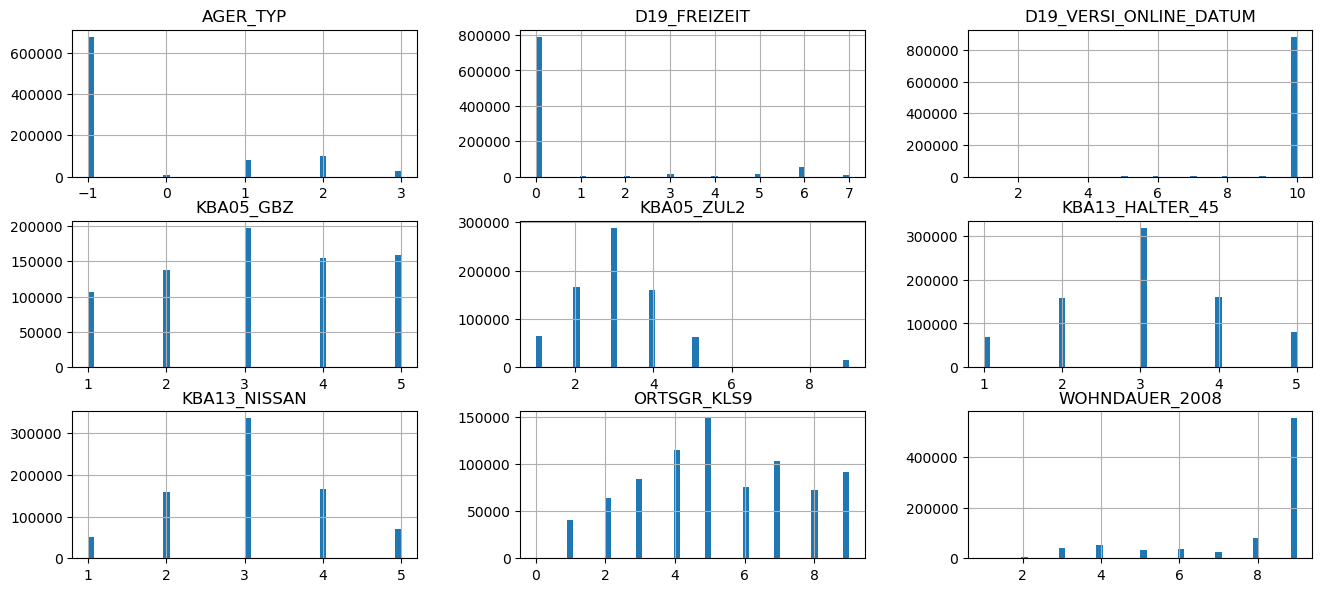

In [6]:
_ = azdias.hist(column=azdias.columns[1::int(azdias.shape[1]//8)], figsize=(16, 7), bins=50)

We found that our data has many missing values and is mostly composed of categorical data. But instead of immediately droping all of them bearing risk of losing too much vailable data, we take a further check by counting the frequency of NaN in each feature. We present **top** 50 frequencies below.

In [7]:
azdias_na_sorted = azdias.isna().mean(axis=0).sort_values(ascending=False)
azdias_na_sorted.iloc[:50]

ALTER_KIND4                    0.998648
ALTER_KIND3                    0.993077
ALTER_KIND2                    0.966900
ALTER_KIND1                    0.909048
EXTSEL992                      0.733996
KK_KUNDENTYP                   0.655967
ALTERSKATEGORIE_FEIN           0.295041
D19_LETZTER_KAUF_BRANCHE       0.288495
D19_LOTTO                      0.288495
D19_VERSI_ONLINE_QUOTE_12      0.288495
D19_BANKEN_ONLINE_QUOTE_12     0.288495
D19_SOZIALES                   0.288495
D19_GESAMT_ONLINE_QUOTE_12     0.288495
D19_KONSUMTYP                  0.288495
D19_TELKO_ONLINE_QUOTE_12      0.288495
D19_VERSAND_ONLINE_QUOTE_12    0.288495
KBA05_MOTOR                    0.149597
KBA05_MOD8                     0.149597
KBA05_MOD4                     0.149597
KBA05_MOD3                     0.149597
KBA05_MOD2                     0.149597
KBA05_SEG1                     0.149597
KBA05_MOD1                     0.149597
KBA05_MAXVORB                  0.149597
KBA05_MAXSEG                   0.149597


From this counting, we can observe:
1. Six of them have more than 90% NaN, which barely contains valuable info for predicting future, so we **drop** them.

In [8]:
print(azdias.shape)
azdias = azdias.loc[:, azdias.isna().mean(axis=0)  <= 0.9]
print(azdias.shape)

(891221, 366)
(891221, 362)


2. Some features like "EINGEFUEGT_AM" and "OST_WEST_KZ" are object-type, i.e., non-numerical data. We take a further check of them:

In [9]:
azdias.iloc[:, [i for i in range(azdias.shape[1]) if azdias.iloc[:, i].dtype == object]].head(7)

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W
5,8C,8,54,D19_ENERGIE,1992-02-12 00:00:00,W
6,4A,4,22,D19_UNBEKANNT,1992-02-12 00:00:00,W


* We verified them one by one against the informational spreads that found "CAMEO_DEU_2015" and "OST_WEST_KZ" are useful featuers including detailed customer information, so we keep them and transform them into categorical values "-1, 1, 2, ... " like other feartures.  

In [10]:
object_to_num_func = lambda seq: seq.replace(seq.unique(), [-1] + list(range(1, len(seq.unique()))), inplace=True)
object_to_num_func(azdias.loc[:, 'CAMEO_DEU_2015'])
object_to_num_func(azdias.loc[:, 'OST_WEST_KZ'])

* "CAMEO_DEUG_2015" and "CAMEO_INTL_2015" are numerical variables but wrongly recorded as string:

In [11]:
print(azdias['CAMEO_DEUG_2015'].unique(), '\n', azdias['CAMEO_INTL_2015'].unique())

[nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X'] 
 [nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44'
 '35' '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45'
 'XX']


so we change them back to digital metrics.

In [12]:
azdias.loc[:, 'CAMEO_DEUG_2015'] = azdias.loc[:, 'CAMEO_DEUG_2015'].fillna(-1).replace({'X':-1}).values.astype(float)
azdias.loc[:, 'CAMEO_INTL_2015'] = azdias.loc[:, 'CAMEO_INTL_2015'].fillna(-1).replace({'XX':-1}).values.astype(float)

* But "D19_LETZTER_KAUF_BRANCHE" and "EINGEFUEGT_AM" don't have useful information, so we drop them.

In [13]:
print(azdias.shape)
azdias.drop(columns=['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM'], inplace=True)
print(azdias.shape)

(891221, 362)
(891221, 360)


3. The rest of features appear to have some _correlationship_ with many of them belonging to the same category and having the same frequency of NaN, like "D19_ ... " and "KBA05_ ... ", which means we can handle them in a similar way. Diving into the informational speadsheets, we found they were numerical categories variables. In addition, because most of them have value "-1" when they are unknown, we decided to **fill NaN with -1** as well to represent this data missing.

In [14]:
azdias.fillna(value= -1, inplace=True)

Now, we merge all the preprocessing steps done above in a function for future usage.

In [15]:
def azdias_data_preprocessing(df):
    ## step 1
    df = df.loc[:, df.isna().mean(axis=0)  <= 0.9]
    
    ## step 2.1
    object_to_num_func = lambda seq: seq.replace(seq.unique(), [-1] + list(range(1, len(seq.unique()))), inplace=True)
    object_to_num_func(df.loc[:, 'CAMEO_DEU_2015'])
    object_to_num_func(df.loc[:, 'OST_WEST_KZ'])
    ## step 2.2
    df.loc[:, 'CAMEO_DEUG_2015'] = df.loc[:, 'CAMEO_DEUG_2015'].fillna(-1).replace({'X':-1}).values.astype(float)
    df.loc[:, 'CAMEO_INTL_2015'] = df.loc[:, 'CAMEO_INTL_2015'].fillna(-1).replace({'XX':-1}).values.astype(float)
    ## step 2.3
    df.drop(columns=['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM'], inplace=True)
    
    ## step 3
    df.fillna(value= -1, inplace=True)
    
    return df

### Secondly, as we finished preprocessing the general population data, we take a look at our customer data.

In [16]:
customers_na_sorted = customers.isna().mean(axis=0).sort_values(ascending=False)
customers_na_sorted.iloc[:50]

ALTER_KIND4        0.998769
ALTER_KIND3        0.993347
ALTER_KIND2        0.973389
ALTER_KIND1        0.938607
KK_KUNDENTYP       0.584064
EXTSEL992          0.444989
KBA05_SEG7         0.292092
KBA05_KW1          0.292092
KBA05_SEG4         0.292092
KBA05_SEG5         0.292092
KBA05_SEG6         0.292092
KBA05_MAXAH        0.292092
KBA05_SEG8         0.292092
KBA05_KW2          0.292092
KBA05_VORB0        0.292092
KBA05_KRSZUL       0.292092
KBA05_VORB1        0.292092
KBA05_KRSVAN       0.292092
KBA05_KRSOBER      0.292092
KBA05_SEG9         0.292092
MOBI_REGIO         0.292092
KBA05_KW3          0.292092
KBA05_SEG3         0.292092
KBA05_KRSHERST3    0.292092
KBA05_MAXBJ        0.292092
KBA05_MAXHERST     0.292092
KBA05_MAXSEG       0.292092
KBA05_MAXVORB      0.292092
KBA05_MOD1         0.292092
KBA05_MOD2         0.292092
KBA05_MOD3         0.292092
KBA05_MOD4         0.292092
KBA05_MOD8         0.292092
KBA05_MOTOR        0.292092
KBA05_MOTRAD       0.292092
KBA05_SEG2         0

This customer data has similar data structure, so we apply the **same preprocessing** methods to it.

In [17]:
customers  = azdias_data_preprocessing(customers)
assert(azdias.shape[1] == (customers.shape[1] - 3))

The customer data has three new features, we manually check them here.

In [18]:
new_features = list(set(customers.columns) - set(azdias.columns))
[('{feature}: {value}'.format(feature=col, value=customers.loc[:, col].unique())) for col in new_features]

["PRODUCT_GROUP: ['COSMETIC_AND_FOOD' 'FOOD' 'COSMETIC']",
 'ONLINE_PURCHASE: [0 1]',
 "CUSTOMER_GROUP: ['MULTI_BUYER' 'SINGLE_BUYER']"]

To make things look more clearly, we replace numerical value "0" and "1" as its real meaning.

In [19]:
customers['ONLINE_PURCHASE'].replace({0:'NOT_ONLINE_PURCHASE', 1:'ONLINE_PURCHASE'}, inplace=True)

### Now, it's time to do PCA

But at first we check whether there are some features not contributing to identifying cutomers, for example, ID helps recognize each individual but not tells characteristics of customers. Because our data mainly includes categorical features ranging in [-1, 0, 1, ... , n], we sort them by the absolute maximal value and look at their magnitudes.

In [20]:
azdias.abs().max().sort_values(ascending=False).head()

LNR                     1082873.0
KBA13_ANZAHL_PKW           2300.0
EINGEZOGENAM_HH_JAHR       2018.0
GEBURTSJAHR                2017.0
MIN_GEBAEUDEJAHR           2016.0
dtype: float64

Looking up the informational spreadsheets, we can find features "KBA13_ANZAHL_PKW", "EINGEZOGENAM_HH_JAHR", etc. useful but "LNR" is missing, so we take a further look at it.

In [21]:
print(azdias['LNR'].unique().shape[0], '\n', azdias['LNR'].head())

891221 
 0    910215
1    910220
2    910225
3    910226
4    910241
Name: LNR, dtype: int64


"LNR" seems to be an ID-like feature, whose magnitude as well as variance is huge, but doesn't provide valuable info, so we **leave it aside** when doing PCA. Moreover, because features 'CUSTOMER_GROUP', 'ONLINE_PURCHASE' and 'PRODUCT_GROUP' are exclusive to customers, we **wouldn't include them** when doing PCA for identifying the general population.  

In [22]:
pca_features = azdias.columns.to_list()
pca_features.remove("LNR")

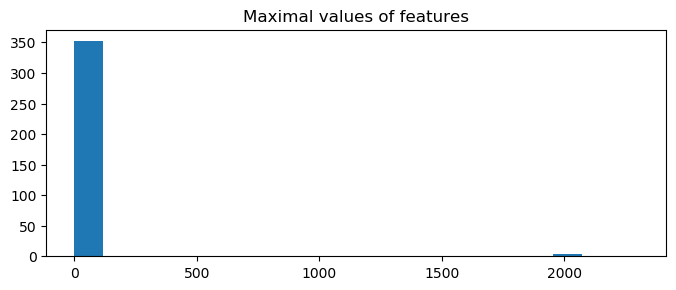

In [23]:
fig = plt.figure(figsize=(8,3))
plt.hist(customers[pca_features].max(axis=0), bins=20)
_ = plt.title('Maximal values of features')

Note some features have different scales from the others, so we should **scale** them to make variance/information not be misjudged by magnitudes.

In [24]:
""" 
    We first make different features have comparable ranges, so we subtract the non-negative
parts by its minimum. For example, [-1,2000,2002,2003] will become [-1,0,2,3] where "-1"
still represents the missing value but the variance range goes back to normal.

    Then, we scale features by their absolute maximal value to avoid variance being eliminated.
"""

customers_pca = customers[pca_features]
customers_NonNegativeMin = np.where(customers_pca<0, np.inf, customers_pca).min(axis=0)
customers_pca = customers_pca - customers_NonNegativeMin

from sklearn.preprocessing import MinMaxScaler
ss_customers = MinMaxScaler()
customer_scaled = ss_customers.fit_transform(customers_pca)

Now we can apply PCA and plot the cumulated sum of explained variance ratio for these PCs.

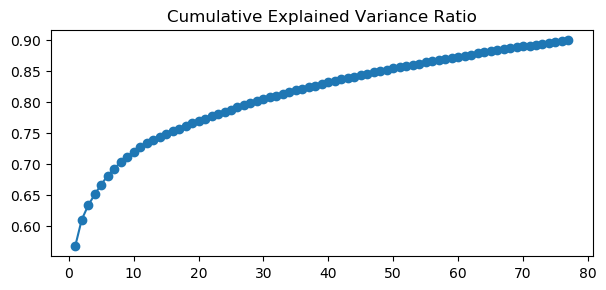

In [25]:
from sklearn.decomposition import PCA
pca = PCA()
customers_PCs = pca.fit_transform(customer_scaled)

cumvar = pca.explained_variance_ratio_.cumsum()
top_cumvar = cumvar[cumvar < 0.9]
plt.figure(figsize=(7,3), dpi=100)
plt.plot(np.arange(len(top_cumvar))+1, top_cumvar, 'o-', )
_ = plt.title('Cumulative Explained Variance Ratio')

We observe that the first 77 PCs can explain about 90% variance, which is a fair choice considering remaining information and computational efficiency, so we use them as the representatives of raw data set.

In [26]:
num_PCs = len(top_cumvar)
print(num_PCs)
customers_PCs = customers_PCs[:, :num_PCs]

77


### With compressed PCs, we can do clustering to tell how likely the population can become our customers.

Note that we fix the random seed to make results reproducible.

In [27]:
RANDOM_SEED = 2020

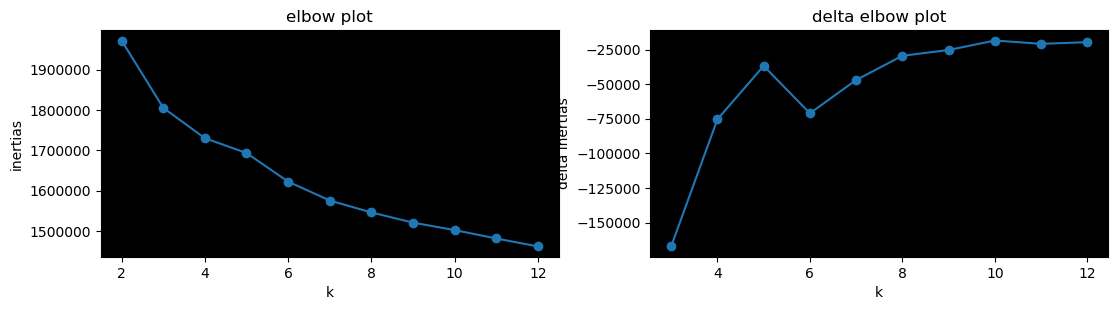

In [28]:
from sklearn.cluster import KMeans
inertias = []

for k in range(2,13):
    kmeans = KMeans(k, random_state=RANDOM_SEED, n_jobs=4).fit(customers_PCs)
    inertias.append(kmeans.inertia_)

fig = plt.figure(figsize=(13, 3))
ax = fig.add_subplot(121, facecolor='black')
ax.plot(list(range(2, 13)), inertias, 'o-')
ax.set_xlabel("k")
ax.set_ylabel("inertias")
ax.set_title('elbow plot')

ax = fig.add_subplot(122, facecolor='black')
ax.plot(list(range(3, 13)), np.diff(inertias), 'o-')
ax.set_xlabel("k")
ax.set_ylabel("delta inertias")
_ = ax.set_title('delta elbow plot')

From the elbow plot and delta elbow plot, we see that **k = 4** would be a good choice because after that the increment of inertias slow down quickly.  

In [29]:
k = 4
kmeans = KMeans(k).fit(customers_PCs)
customers_pred = kmeans.predict(customers_PCs)

Now use the three new features to describe customers characteristics behind our clusterning result.

In [30]:
## convert text data into numerical foramt so that it's easier to count 
_dict_to_num = lambda obj: dict(zip(np.unique(obj), np.arange(np.unique(obj).shape[0])))

belongings = pd.DataFrame(np.zeros((k, len(new_features))), index=['Cluster {}'.format(i) for i in range(k)], columns=new_features)
for x in new_features:
    feature = customers[x].replace(_dict_to_num(customers[x]))
    for cluster in range(k):
        feature_count = np.bincount(feature.iloc[customers_pred == cluster])
        belongings.iloc[cluster, np.argmax(feature_count)] = np.max(feature_count)/np.sum(feature_count)
belongings

,PRODUCT_GROUP,ONLINE_PURCHASE,CUSTOMER_GROUP
Cluster 0,0.655423,0.484813,0.0
Cluster 1,0.655798,0.494536,0.0
Cluster 2,0.744611,0.582671,0.0
Cluster 3,0.708130,0.548600,0.0


To make things more clearly, we **visualize the result in 2D**, i.e., using two PCs, to see if these clusters are really well seperated.

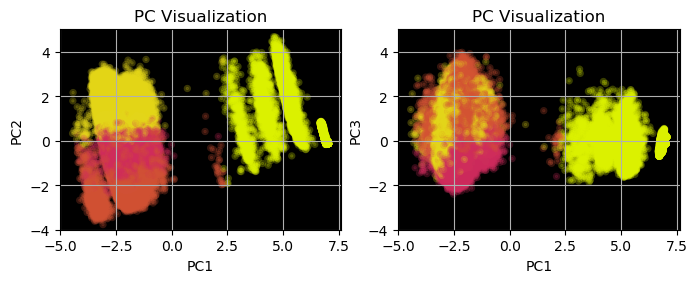

In [31]:
np.random.seed(RANDOM_SEED)

# For best effect, points should not be drawn in sequence but in random order
randomorder=np.random.permutation(np.arange(customers_pred.shape[0]))

# Set colors
colors=np.zeros((customers_pred.shape[0], 4))
for cluster in range(k):
    colors[customers_pred==cluster, :3] = np.random.rand(3) # make  points have random colors
colors[:, 3] = 0.25 # make  points have opacity 0.25

# Draw scatter plot
fig = plt.figure(figsize=(8, 3))
for i in range(2):
    ax = fig.add_subplot(121+i, facecolor='black')
    ax.scatter(customers_PCs[randomorder,0], customers_PCs[randomorder, i+1],s=5,linewidths=3,facecolors=colors[randomorder,:],marker="o")
    ax.set_aspect('equal')
    ax.set_xlabel("PC1"); ax.set_ylabel("PC{}".format(i+2))
    ax.set_ylim([-4, 5])
    ax.set_title('PC Visualization')
    ax.grid(True)

We see that clusters can be well seperated as we gradually enter into **higher dimension**. Next, we can predict the general population based on our k-means model. But before that, we need to preprocess and transform population data into PCs **using pre-trained parameters**.

In [32]:
azdias_pca = azdias[pca_features]
azdias_NonNegativeMin = np.where(azdias_pca<0, np.inf, azdias_pca).min(axis=0)
azdias_pca = azdias_pca - azdias_NonNegativeMin

azdias_scaled = ss_customers.transform(azdias_pca)
azdias_PCs = pca.transform(azdias_scaled)[:, :num_PCs]

Finally, we can make predictions and calculate the distances between individuals and their belongings to tell how likely it is true.

In [33]:
azdias_cluster = kmeans.predict(azdias_PCs)

azdias_dist = kmeans.transform(azdias_PCs).min(axis=1).round(3)
azdias_dist_sorted = np.argsort(azdias_dist)

As the minimal distances have a fairly large range, we need to set a reasonable threshold to make predictions. A natural choice is rmsd(root mean square distances) using customers clustering result. To be specific, we predict individuals less than **0.5 $\times$ rmsd** away from their closest center as potential customers and people more than **1.5 $\times$ rmsd** away as unlikely.

In [34]:
rmsd_thresh = np.sqrt(kmeans.inertia_ / customers.shape[0])

potential_customers = azdias[azdias_dist < 0.5 * rmsd_thresh]
unlikely_customers = azdias[azdias_dist > 1.5 * rmsd_thresh]
print('prediction_threshold:{thresh}, number of potential customers:{x1}, number of unlikely customers:{x2}'.format(\
                    thresh=round(rmsd_thresh,3), x1=potential_customers.shape[0], x2=unlikely_customers.shape[0]))

prediction_threshold:3.005, number of potential customers:63288, number of unlikely customers:72270


We visualize our predictions to have a clear understanding.

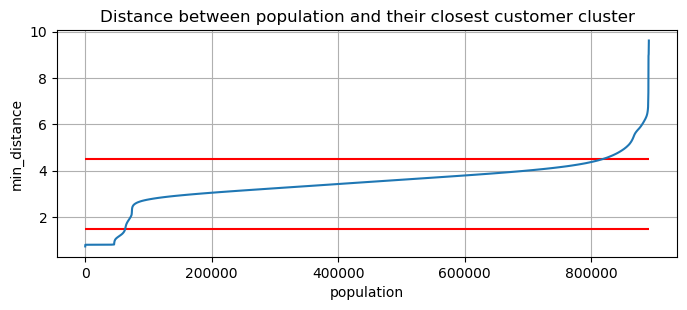

In [35]:
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111)
ax.plot(azdias_dist[azdias_dist_sorted])
ax.hlines([0.5 * rmsd_thresh, 1.5 * rmsd_thresh], 0, azdias_dist.shape[0], colors='r')
ax.set_xlabel("population"); ax.set_ylabel("min_distance")
ax.set_title('Distance between population and their closest customer cluster')
ax.grid(True)

Combining our cluster predictions and corresponding customers characteristics, we can have some anticipations about prospective customers. 

In [36]:
potential_customers.insert(0, 'Cluster', azdias_cluster[azdias_dist < 0.5 * rmsd_thresh])
potential_customers.head()

,Cluster,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1,910215,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3,1,2
11,1,645169,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3,1,2
14,1,612565,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3,1,3
17,1,612577,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3,1,2
24,1,703164,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3,2,3


In [37]:
unlikely_customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
9,645153,-1,5.0,17.0,17.0,9.0,0.0,0.0,1.0,7.0,...,4.0,1.0,1.0,1.0,4.0,3.0,7.0,4,2,3
13,612561,-1,8.0,20.0,20.0,2.0,0.0,0.0,1.0,2.0,...,-1.0,3.0,6.0,8.0,6.0,3.0,5.0,5,2,1
15,612569,1,9.0,11.0,11.0,1.0,0.0,0.0,1.0,1.0,...,4.0,6.0,6.0,3.0,6.0,4.0,3.0,3,2,4
20,612594,-1,7.0,0.0,-1.0,1.0,0.0,0.0,1.0,1.0,...,-1.0,8.0,11.0,10.0,3.0,4.0,5.0,3,2,2
23,612609,-1,6.0,16.0,-1.0,1.0,0.0,0.0,2.0,1.0,...,2.0,3.0,6.0,8.0,3.0,2.0,3.0,4,1,3


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### First, we preprocess data and select appropriate evaluation metrics.

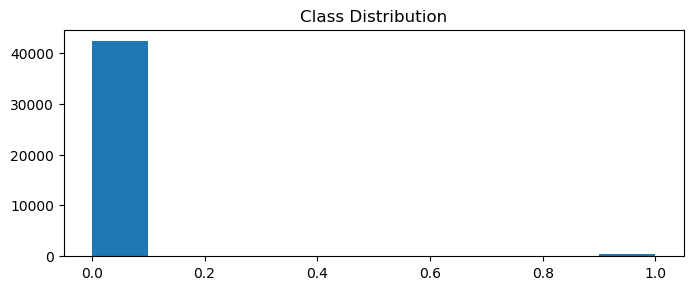

In [38]:
mailout_train = pd.read_csv(os.path.join(os.getcwd(), 'mailout_train.csv'), sep=';')
plt.figure(figsize=(8,3))
plt.hist(mailout_train['RESPONSE'])
_ = plt.title('Class Distribution')

In [39]:
mailout_train  = azdias_data_preprocessing(mailout_train)
assert((mailout_train.shape[1] - 1) == (customers.shape[1] - 3))

Then, we calculate minimal distances between individuals and their closest customer cluster and add this new feature to their demographic info data set. 

In [40]:
from sklearn.preprocessing import MinMaxScaler
mailout_train_pca = mailout_train[pca_features]
mailout_train_NonNegativeMin = np.where(mailout_train_pca<0, np.inf, mailout_train_pca).min(axis=0)
mailout_train_pca = mailout_train_pca - mailout_train_NonNegativeMin

ss_mailout_train = MinMaxScaler()
mailout_train_scaled = ss_mailout_train.fit_transform(mailout_train_pca)
mailout_train_PCs = pca.transform(mailout_train_scaled)[:, :num_PCs]
mailout_train_dist = kmeans.transform(mailout_train_PCs).min(axis=1).round(3)

mailout_train['CLUSTER_DIST'] = mailout_train_dist

Now, we can seperate the whole data to X, all features but "LNP" and "RESPONSE" and y, targeted people's response.

In [41]:
X, y = mailout_train.drop(columns=['LNR', 'RESPONSE']).values, mailout_train['RESPONSE'].values

Before directly researching on all features, we first carry out feature selection.

In [42]:
y.mean()

0.012383036171500396

We notice the imbalance is extremely serious that only about 1% labels are positive. In this situation, directly using accuracy would be **misleading**  because we can naively make all outputs to be 0 and achieve nearly 99% accuracy but this is useless. Thus, we should think about ways to remedy:
1. **F1-score**: F1-socre combines precision and recall together. Recall represents our ability to identify potential customers, which is the main purpose of our model, while precision decides how likely we won't end up wasting our time and bothering people to further alienate them.
2. **AUC metric**: AUC is less sensitive to class imbalance. It doesn't set a hard threshold but forces classifier to generate a distinct decision boundary, i.e., higher values for positive labels.
3. **Balanced weights**: We can make cost function more sensitive to positive classes by assigning to them more weight because they are what interests us and deserve more attention.
4. **Undersampling**: Sample from majority class to make problem balanced, but this is dangerous since it loses a lot of information.
5. **Oversampleing**: Sample from minority class to make problem balanced, this could be promising but also at risk of overfitting handy data.
6. **Undersampling + Ensemble**: This is an advanced realization of # 3, which undersamples from majority class and trains a classifier each time until looking through all data, then we ensemble all the models by considering their votes with equal weights to make predictions.
7. **Undersampling + Oversampleing + Ensemble**: In # 5, each "sub-dataset" is very small, making data distribution too skewed to learn, so we combine # 4 together by dividing/undersampling majority data into N splits, oversampling from minority class to achieved balance, training models and finally doing ensembles.

### Instead of directly researching on all features, we do feature selection to choose the suitable ones.

In [43]:
""" 
    We check pearson correlation although our feartures are mostly categorical, for example:
    
    1. np.corrcoef(np.arange(6), np.array([-1,0,2,3,5,11]))[0, 1]  --> 0.94
    2. spearmanr(np.arange(6), np.array([-1,0,2,3,5,11]))[0]  --> 1.0
    
    Pearson corrleation also considers the variance information which is important. Then, we
reject the pairs with correlation > 0.9 and keep the one with largest variance.
    
    However, we need to make different features comparable, so we subtract the non-negative
parts by its minimum. For example, [-1,2000,2002,2003] --> [-1,0,2,3] so that "-1" will still
represent the missing value, but the magnitude is scaled to right. 
"""

NonNegativeMin = np.where(X<0, np.inf, X).min(axis=0)
X = X - NonNegativeMin

rhos = np.corrcoef(X, rowvar=False)
variances = X.var(axis=0)

corr_thresh = 0.90
feature_kept = []
for i in range(X.shape[1]):
        colinearity_loc = np.where(np.abs(rhos[:, i]) > corr_thresh)[0]
        self_var = variances[i]
        competitors_var = variances[colinearity_loc]
        ## we keep this feature if no other one is significantly correlated with it or it has the largest variance.
        if competitors_var.shape[0] == 0 or self_var >= np.max(competitors_var):
            feature_kept.append(i)
feature_kept = np.array(feature_kept)

In [44]:
print(X.shape)
X = X[:, feature_kept]
print(X.shape)

(42962, 360)
(42962, 278)


Next, we apply RandomForest Classifier for doing an embedded feature selection by setting max_feature = 1, i.e., selecting a single feature each time to observe its capacity to decrease the objective function.

(Note that this is am **in-sample(IS)** method.)

In [45]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=2*X.shape[1], max_features=1, random_state=RANDOM_SEED, n_jobs=4)
rfc.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=1,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=556, n_jobs=4,
                       oob_score=False, random_state=2020, verbose=0,
                       warm_start=False)

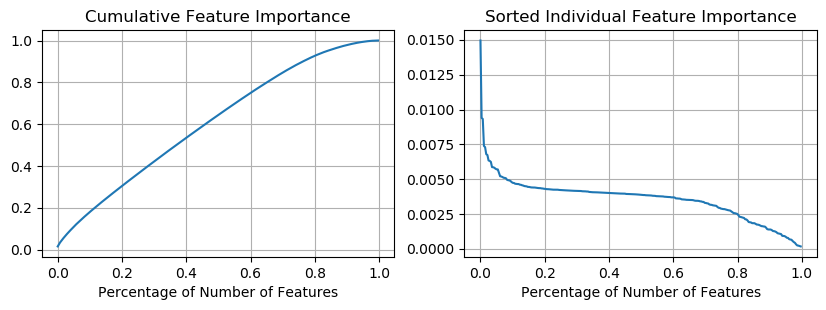

In [46]:
feature_imp = rfc.feature_importances_
imp_argsort = np.argsort(feature_imp)[::-1]
num_feature = feature_imp.shape[0]

fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(121)
ax.plot(np.arange(0,1,1/num_feature), feature_imp[imp_argsort].cumsum())
ax.set_xlabel("Percentage of Number of Features")
ax.set_title('Cumulative Feature Importance')
ax.grid()

ax = fig.add_subplot(122)
ax.plot(np.arange(0,1,1/num_feature), feature_imp[imp_argsort])
ax.set_xlabel("Percentage of Number of Features")
ax.set_title('Sorted Individual Feature Importance')
_ = ax.grid()

We observe that umulative feature importances are roughly linearly increasing, but this trend stops at **90%** features, so we drop those unuseful ones.

In [47]:
print(X.shape)
feature_kept = imp_argsort[:int(0.9*imp_argsort.shape[0])]
X = X[:, feature_kept]
print(X.shape)

(42962, 278)
(42962, 250)


Finally, because the responses in test data are unknown, we randomly extract a dataset **only for evaluation purpose**. 
* When assigning weights, we **ignore the evaluation set** since future data is very likely imbalanced as well, we don't want our artificial manipulations to have any impact on the evaluation result.
* Since our models mostly use regularization for avoiding overfitting, we **scale** our data to make each feature comparable in magnitude.

(By the way, at this moment our preprocessing is rough because cross-validate set should not be included in standardization, we do this **just for simplicity**.)

In [48]:
""" We again fix the random seed to make results from different models comparable and reproducible. """
from sklearn.model_selection import train_test_split
neval = X.shape[0] // 5
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=neval, shuffle=True, random_state=RANDOM_SEED)

n_major, n_minor, n_all = (y_train == 0).sum(), (y_train == 1).sum(), y_train.shape[0]
weights_train = np.where(y_train == 1, n_all / n_minor, n_all / n_major)

from sklearn.preprocessing import MinMaxScaler
ss_X_train = MinMaxScaler().fit(X_train)
X_train, X_eval = ss_X_train.transform(X_train), ss_X_train.transform(X_eval)

Here, we define a customized function wraping metrics mentioned above to report and visulize model performance for a comprehensive evaluation.

In [49]:
def ensemble_proba(ensemble:list, X, y):
    import xgboost as xgb
    
    ## calculate prediction probability of each classifier and ensemble them using average
    pred = [clf.predict(xgb.DMatrix(X, y)) if isinstance(clf, xgb.Booster)
                   else clf.predict_proba(X)[:,1] if hasattr(clf, 'predict_proba')
                   else 1/(1+np.exp(-clf.decision_function(X))) if hasattr(clf, 'decision_function')
                   else clf.predict(X) for clf in ensemble]
    return np.vstack([pred]).mean(axis=0)
    
def print_report(ensemble:list, X_train, X_val, y_train, y_val, thresh=0.5, labels = ['Not Response', 'Response']):
    """
    Prints a classification report on both validation and training set.
    
    (1) Metrics include AUC, F1, Precision, Recall and Confusion Matrix.
    (2) Input "ensemble" accepts both single classifiers and ensembles.
    (3) Results are dependent on the probability threshold "thresh".
    """
    results = {}
    y_train_proba, y_val_proba = ensemble_proba(ensemble, X_train, y_train), ensemble_proba(ensemble, X_val, y_val)
    y_train_pred, y_val_pred = np.where(y_train_proba >= thresh, 1, 0), np.where(y_val_proba >= thresh, 1, 0)
    results.update(train={'proba':y_train_proba,'pred':y_train_pred},
                           val={'proba':y_val_proba, 'pred':y_val_pred})
    
    from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, confusion_matrix
    print('\t\t\t        Train: AUC: {x1}, F1: {x2}, Recall:{x3}, Precision:{x4}'.format(x1=round(roc_auc_score(y_train, y_train_proba),3),\
                x2=round(f1_score(y_train, y_train_pred), 3),  x3=round(recall_score(y_train, y_train_pred), 3), x4=round(precision_score(y_train, y_train_pred), 3)))
    
    print('\t\t\tValidation: AUC: {x1}, F1: {x2}, Recall:{x3}, Precision:{x4}'.format(x1=round(roc_auc_score(y_val, y_val_proba),3),\
                x2=round(f1_score(y_val, y_val_pred), 3),  x3=round(recall_score(y_val, y_val_pred), 3), x4=round(precision_score(y_val, y_val_pred), 3)))
    
    cm_val = confusion_matrix(y_val, y_val_pred)
    import seaborn as sns
    fig, ax = plt.subplots(1, 1, figsize=(8, 3))
    sns.heatmap(cm_val, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap=plt.cm.Blues, ax=ax)
    ax.set_title('Confusion matrix on evaluation set'); ax.set_ylabel('True'); ax.set_xlabel('Predict')
    return results

### Next, we compare candidate models and select the most promising one to be further improved. 

Before we start, a **benchmark** should be set to help understand how our candidates perform. Given that there are about 1.23% positive labels, as accuracy is no longer an impartial metric, we should expect classifiers to give recall and precision at least at 1.23% to be unusual. Otherwise, blindly making positive predictions works better. 

1. First, we check out how logistic regression works in this situation, this simplest classifier gives a **benchmark** to weigh the performance of other sophisticated models.

In [50]:
""" 
    To remain validation set unchanged for maintaining the reality and to resample without replacement
for fully utlizing information, we customize a cross-validation spliter here. 
    Also, we fix the random seed to make results from different models comparable and reproducible.
"""

def MyStratifiedCV(X, y, n_splits, seed=RANDOM_SEED):
    """ 
        We make a stratified CV split without replacement so that each split has similar data strucutre and thus
    can be equally weighted when voting for choosing hyper-parameter.
    """
    if n_splits == 1: ## when we're training models on the entire data set for prediction
        yield (np.arange(y.shape[0]), [])
    else: ## when we're doing cross-validation for hyper-parameter tuning
        np.random.seed(seed)
        ## Now we make each split have strictly stratified data, i.e., their classes imbalance levels should be same.
        major_idx = np.where(y == 0)[0]
        MajorRandomSamples = np.random.choice(major_idx, size=(n_splits, len(major_idx)//n_splits), replace=False)
        leftout_idx1 = np.array(list(set(major_idx) - set(MajorRandomSamples.ravel()))).astype(int) ## idx not sampled
        
        minor_idx = np.where(y == 1)[0]
        MinorRandomSamples = np.random.choice(minor_idx, size=(n_splits, len(minor_idx)//n_splits), replace=False)
        leftout_idx2 = np.array(list(set(minor_idx) - set(MinorRandomSamples.ravel()))).astype(int) ## idx not sampled
        for i in range(n_splits):
            val_idx = np.hstack([MajorRandomSamples[i], MinorRandomSamples[i]])
            if i == 0:
                val_idx = np.hstack([val_idx, leftout_idx1, leftout_idx2])
            train_idx = np.array(list(set(np.arange(y.shape[0])) - set(val_idx)))
            yield (train_idx, val_idx)

In [51]:
print(X_train.shape)

## The size of training is dividable by 7, so we will use 7-fold cross-validation along this project.
n_splits = 7
my_cv_weighted = list(MyStratifiedCV(X_train, y_train, n_splits))

(34370, 250)


In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
def lr_HyperParamTuning(CVspliter, X, y, seed=RANDOM_SEED, class_weight=None):
    """ 
        A rought hyper-parameter tuning process for SVC using random girdsearch.
    The main purpose is to more efficiently determine the way to overcome class imbalance.
    """
    lr_param_dist = {'C': np.logspace(-2,2,10),
                        'random_state': [seed]}
    lr_rscv_params = {'n_iter':10,
                      'cv':CVspliter,
                      'scoring':'roc_auc',
                      'random_state':seed, 
                      'n_jobs': 4}
    start = time.time()
    lr_rscv = RandomizedSearchCV(LogisticRegression(class_weight=class_weight), lr_param_dist, **lr_rscv_params).fit(X, y)
    print("best logistic regression params:{}".format(lr_rscv.best_params_))
    print("\t\t\t        Time:{cost}s".format(cost=round(time.time()-start,3)))
    return lr_rscv

best logistic regression params:{'random_state': 2020, 'C': 0.01}
			        Time:59.542s
			        Train: AUC: 0.782, F1: 0.055, Recall:0.744, Precision:0.028
			Validation: AUC: 0.686, F1: 0.041, Recall:0.583, Precision:0.021


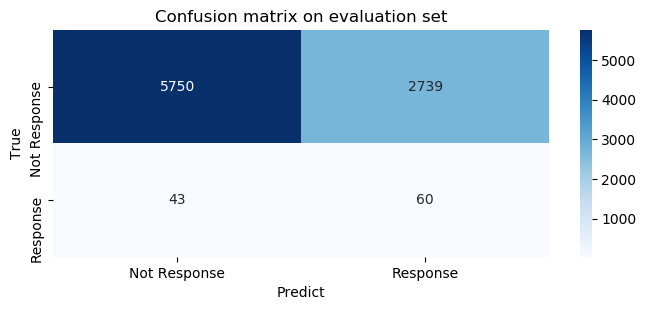

In [53]:
lr_rscv_weighted = lr_HyperParamTuning(my_cv_weighted, X_train, y_train, class_weight='balanced')
lr_model_weighted = lr_rscv_weighted.best_estimator_
_ = print_report([lr_model_weighted], X_train, X_eval, y_train, y_eval)

Our benchmark model assigns the imbalance ratio of two classes as weight to the minority class, uses AUC as metric, and finally gets AUC=0.769 and F1=0.096 on the validation set. And from confusion matrix we know that the precision is poor.

2. Next, we try SVC and see how it performs.

In [54]:
from sklearn.svm import LinearSVC
def svc_HyperParamTuning(CVspliter, X, y, seed=RANDOM_SEED, class_weight=None):
    """ 
        A rought hyper-parameter tuning process for SVC using random girdsearch.
    The main purpose is to more efficiently determine the way to overcome class imbalance.
    """
    svc_param_dist={ 'C': np.logspace(-2, 2, 10)}
    svc_rscv_params={'n_iter':10,
                        'cv':CVspliter,
                        'scoring':'roc_auc',
                        'random_state':seed,
                        'n_jobs': 4}
    start = time.time()
    svc_rscv = RandomizedSearchCV(LinearSVC(class_weight=class_weight), svc_param_dist, **svc_rscv_params).fit(X, y)
    
    print("best svc params:{}".format(svc_rscv.best_params_))
    print("\t\t\t        Time:{cost}s".format(cost=round(time.time()-start,3)))
    return svc_rscv

best svc params:{'C': 0.01}
			        Time:533.387s
			        Train: AUC: 0.8, F1: 0.059, Recall:0.765, Precision:0.031
			Validation: AUC: 0.676, F1: 0.041, Recall:0.553, Precision:0.021


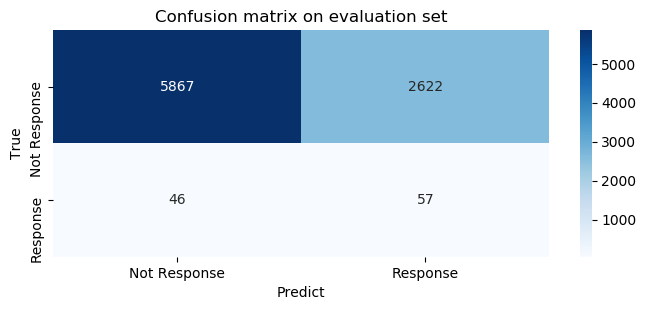

In [55]:
svc_rscv_weighted = svc_HyperParamTuning(my_cv_weighted, X_train, y_train, class_weight='balanced')
svc_model_weighted = svc_rscv_weighted.best_estimator_
_ = print_report([svc_model_weighted], X_train, X_eval, y_train, y_eval)

3. We also use Random Forest Classifier to solving the problem

In [56]:
import xgboost as xgb
def MyRandomSearchCV(dtrain, raw_params, params_dist, folds=None, maximize=False, num_boost_round=150, verbose=False):
    """ 
        A customized RandomGirdSearchCV to support XGBoost model.
    """
    best_metric, best_std = -np.inf if maximize else np.inf, np.inf
    best_index, best_params, cv_results = 0, [], []
    
    xgb_params = copy.deepcopy(raw_params)
    metric = raw_params['eval_metric']
    ## ====================== RandomSearchCV starts
    for i,params in enumerate(params_dist):
        ## XGB training ...
        xgb_params.update(params)
        xgbcv = xgb.cv(xgb_params, dtrain, num_boost_round, folds=folds, early_stopping_rounds=15, shuffle=False)
        curr_metric, curr_std = xgbcv.iloc[-1, -2], xgbcv.iloc[-1, -1]
        
        ##  Update the best parameters when objective is improved or objective hangs around but std decreases
        if  i == 0\
            or not maximize and curr_metric < best_metric\
            or maximize and curr_metric > best_metric:
                best_index, best_metric, best_std, best_params, cv_results = i, curr_metric, curr_std, params, xgbcv
        
        ## Print cv information
        if verbose:
            x1, x2, x3, x4 = np.round(xgbcv.iloc[-1, -4:], 4)
            print("=======> {n_iter}-th search, train_{metric}:{x1}, train_std:{x2}, val_{metric}:{x3}, val_std:{x4}"
                                        .format(n_iter=i+1, metric=metric, x1=x1, x2=x2, x3=x3, x4=x4))
    ## ====================== RandomSearchCV ends
    print('best_params:{}, best_{}(val):{}'.format(best_params, metric, round(best_metric, 4)))
    return {'cv_results':cv_results, 'best_index':best_index, 'best_params':best_params, 'best_metric':best_metric}

In [57]:
def rfc_HyperParamTuning(CVsplits, dtrain, seed=RANDOM_SEED, max_bin=256, verbose=False):
    """ 
        A rough hyper-parameter tuning process for XGBoost Random Forest using random girdsearch.
    The main purpose is to more efficiently determine the way to overcome class imbalance.
    """
    from sklearn.model_selection import ParameterSampler
    rfc_params= {'objective':'binary:logistic', 'eval_metric':'auc', 'tree_method':'hist', 'max_bin':max_bin,
            'eta':1, 'colsample_bynode':np.sqrt(dtrain.num_col())/dtrain.num_col(), 'subsample':0.8, 'seed':seed, 'nthread':8}
    
    start = time.time()
    ##### ================== Hyper-Parameter Tuning Start
    ## We first tune the most important num_parallel_tree and max_depth using grid-search
    rfc_param_grid ={'num_parallel_tree': np.arange(100, 701, 100)}
    rfc_param_dist = ParameterSampler(rfc_param_grid, n_iter=7, random_state=seed)
    rfc_rscv = MyRandomSearchCV(dtrain, rfc_params, rfc_param_dist, folds=CVsplits, maximize=True, num_boost_round=1, verbose=verbose)
    rfc_params.update(rfc_rscv['best_params'])
    
    rfc_param_grid={'max_depth': np.arange(2,13,2)}
    rfc_param_dist = ParameterSampler(rfc_param_grid, n_iter=6, random_state=seed)
    rfc_rscv = MyRandomSearchCV(dtrain, rfc_params, rfc_param_dist, folds=CVsplits, maximize=True, num_boost_round=1, verbose=verbose)
    rfc_params.update(rfc_rscv['best_params'])
    
    ## We then tune less important 'colsample_bynode' and 'subsample' using random grid-search
    rfc_param_grid={'colsample_bynode': 0.01 * (2**np.arange(6)),
                                   'subsample': np.arange(0.7, 0.91, 0.1)}
    DefaultParam = {'colsample_bynode':rfc_params['colsample_bynode'], 'subsample':rfc_params['subsample']} ## In case the default works best
    rfc_param_dist = list(ParameterSampler(rfc_param_grid, n_iter=7, random_state=seed)) + [DefaultParam]
    rfc_rscv = MyRandomSearchCV(dtrain, rfc_params, rfc_param_dist, folds=CVsplits, maximize=True, num_boost_round=1, verbose=verbose)
    rfc_params.update(rfc_rscv['best_params'])
    
    ## 3. We don't tune min_child_weight', 'gamma' and 'lambda' because it's ok for each signle tree to grow deeply
    ##### ================== Hyper-Parameter Tuning End
    print("\t\t\t        Time:{cost}s".format(cost=round(time.time()-start,3)))
    return rfc_params, rfc_rscv

In [58]:
dtrain_weighted = xgb.DMatrix(X_train, y_train, weights_train)

=======> 1-th search, train_auc:0.9329, train_std:0.0049, val_auc:0.7212, val_std:0.0268
=======> 2-th search, train_auc:0.9339, train_std:0.0029, val_auc:0.7225, val_std:0.0304
=======> 3-th search, train_auc:0.9335, train_std:0.0022, val_auc:0.7243, val_std:0.0284
=======> 4-th search, train_auc:0.9337, train_std:0.002, val_auc:0.7249, val_std:0.028
=======> 5-th search, train_auc:0.9338, train_std:0.0021, val_auc:0.7246, val_std:0.027
=======> 6-th search, train_auc:0.934, train_std:0.0025, val_auc:0.7253, val_std:0.0275
=======> 7-th search, train_auc:0.9338, train_std:0.0024, val_auc:0.7255, val_std:0.0269
best_params:{'num_parallel_tree': 700}, best_auc(val):0.7255
=======> 1-th search, train_auc:0.7878, train_std:0.0042, val_auc:0.7257, val_std:0.0213
=======> 2-th search, train_auc:0.8557, train_std:0.0037, val_auc:0.7306, val_std:0.0215
=======> 3-th search, train_auc:0.9338, train_std:0.0024, val_auc:0.7255, val_std:0.0269
=======> 4-th search, train_auc:0.977, train_std:0.00

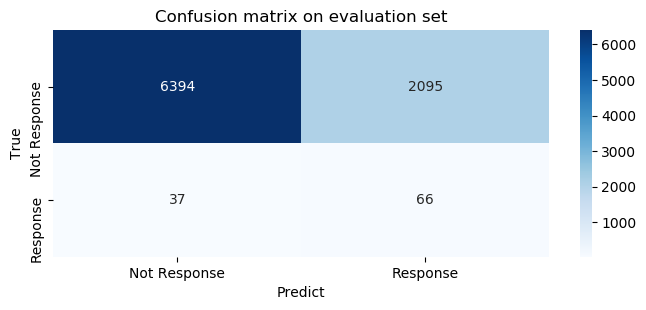

In [59]:
rfc_params_weighted, rfc_rscv_weighted = rfc_HyperParamTuning(my_cv_weighted, dtrain_weighted, verbose=True)
rfc_model_weighted = xgb.train(rfc_params_weighted, dtrain_weighted, rfc_rscv_weighted['cv_results'].shape[0], verbose_eval=False)
_ = print_report([rfc_model_weighted], X_train, X_eval, y_train, y_eval)

4. Finally, we apply the powreful XGBoost Classifier. And to use XGB API for computational efficiency, we also define a customized RandomGridSearchCV for tuning hyper-parameter.

In [60]:
import xgboost as xgb
def xgb_HyperParamTuning(CVsplits, dtrain, seed=RANDOM_SEED, max_bin=256, verbose=True):
    """ 
        A rought hyper-parameter tuning process for XGBoost using random girdsearch.
    The main purpose is to more efficiently determine the way to overcome class imbalance.
    """
    from sklearn.model_selection import ParameterSampler
    xgb_params= {'objective':'binary:logistic', 'eval_metric':'auc', 'tree_method':'hist', 'max_bin':max_bin, 'nthread':8}
    
    start = time.time()
    ##### ================== Hyper-Parameter Tuning Start
    ## We only tune the important ones, 'eta' and 'max_depth', using grid-search
    xgb_param_grid={'eta': np.logspace(-2, -0.7, 7),
                                   'max_depth': [2]}
    xgb_param_dist = ParameterSampler(xgb_param_grid, 7, seed)
    xgb_rscv = MyRandomSearchCV(dtrain, xgb_params, xgb_param_dist, folds=CVsplits, maximize=True, verbose=verbose)
    xgb_params.update(xgb_rscv['best_params'])
    
    xgb_param_grid={ 'max_depth': np.arange(1,4)}
    xgb_param_dist = ParameterSampler(xgb_param_grid, 3, seed)
    xgb_rscv = MyRandomSearchCV(dtrain, xgb_params, xgb_param_dist, folds=CVsplits, maximize=True, verbose=verbose)
    xgb_params.update(xgb_rscv['best_params'])
    
    ## 2. 'min_child_weight' and 'gamma'
    xgb_param_grid={'min_child_weight': 2**np.arange(5),  ## Our dataset is large, so using 1,2,3,4,... is meaningless
                                    'gamma': np.append(0, 2**np.arange(4))}
    DefaultParam = {'min_child_weight':1, 'gamma':0}                                ## In case the default works best
    xgb_param_dist = [DefaultParam] + list(ParameterSampler(xgb_param_grid, 5, seed))
    xgb_rscv = MyRandomSearchCV(dtrain, xgb_params, xgb_param_dist, folds=CVsplits, maximize=True, verbose=verbose)
    xgb_params.update(xgb_rscv['best_params'])
    ##### ================== Hyper-Parameter Tuning End
    print("\t\t\t        Time:{cost}s".format(cost=round(time.time()-start,3)))
    return xgb_params, xgb_rscv

=======> 1-th search, train_auc:0.754, train_std:0.004, val_auc:0.7464, val_std:0.0172
=======> 2-th search, train_auc:0.7543, train_std:0.004, val_auc:0.7463, val_std:0.0172
=======> 3-th search, train_auc:0.7523, train_std:0.0028, val_auc:0.746, val_std:0.0157
=======> 4-th search, train_auc:0.8029, train_std:0.0022, val_auc:0.7698, val_std:0.0226
=======> 5-th search, train_auc:0.8104, train_std:0.0019, val_auc:0.7691, val_std:0.0208
=======> 6-th search, train_auc:0.8016, train_std:0.0027, val_auc:0.7673, val_std:0.0215
=======> 7-th search, train_auc:0.802, train_std:0.0027, val_auc:0.7709, val_std:0.0178
best_params:{'max_depth': 2, 'eta': 0.19952623149688797}, best_auc(val):0.7709
=======> 1-th search, train_auc:0.8005, train_std:0.0032, val_auc:0.7694, val_std:0.0164
=======> 2-th search, train_auc:0.802, train_std:0.0027, val_auc:0.7709, val_std:0.0178
=======> 3-th search, train_auc:0.8125, train_std:0.0034, val_auc:0.761, val_std:0.0233
best_params:{'max_depth': 2}, best_auc

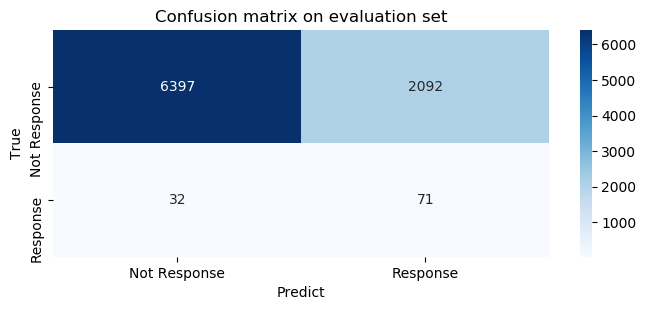

In [61]:
xgb_params_weighted, xgb_rscv_weighted = xgb_HyperParamTuning(my_cv_weighted, dtrain_weighted, verbose=True)
xgb_model_weighted = xgb.train(xgb_params_weighted, dtrain_weighted, xgb_rscv_weighted['cv_results'].shape[0], verbose_eval=False)
_ = print_report([xgb_model_weighted], X_train, X_eval, y_train, y_eval)

5. We will NOT apply neural network here although it's powerful, because our handy data set is relatively too small for it to demonstrate its capability.

### Then, we determine the way to tackle the classes imbalance problem.

With a rough parameter tuning we see that **XGBoost** gives the best AUC with cheap computational cost, so after we will use it as our main model to determine which method among following to use for handling class imbalance:  
1. Unbalanced weight assignment;  
2. Oversampling;  
3. Undersampling + Ensemble;  
4. Undersampling + Oversampling + Ensemble.

1.(1) Oversampling: Note our features are mostly **categorical**, methods like **[SMOTE and ADASYN](https://imbalanced-learn.org/stable/over_sampling.html) are improper**, so we just try ** Random Oversampling**.

In [62]:
""" We recreate training set because this time we plan to solve the imbalance problem by sampling, both classes should have the same weights. """
dtrain = xgb.DMatrix(X_train, y_train)

In [63]:
def MyOverSampler(X, y, idx, seed):
    """ Do over-sampling without random picks so that each data point has the same weight. """
    np.random.seed(seed)
    if y[idx].mean() == 0.5:
        return np.random.permutation(idx)
    major_idx, minor_idx = idx[y[idx]==0], idx[y[idx]==1]
    n_major, n_minor = major_idx.shape[0], minor_idx.shape[0]
    idx_ros = np.hstack([major_idx, np.tile(minor_idx, n_major//n_minor + 1)[:n_major]])
    ## make sure that we've achieved class imbalance
    assert(y[idx_ros].mean() == 0.5) 
    return np.random.permutation(idx_ros)

def MyOverSamplerCV(X, y, n_splits, seed=RANDOM_SEED):
    """ 
        Make a stratified CV split without replacement so that each split has similar data strucutre and
    thus can be equally weighted when voting for choosing hyper-parameter.
    """
    for train_idx, val_idx in MyStratifiedCV(X, y, n_splits, seed=seed):
        train_idx_ros = MyOverSampler(X, y, train_idx, seed)
        yield (train_idx_ros, val_idx)

def getBestModels(X, y, cvSpliter, xgb_params={}, ntrees=None, sklearn_model=None):
    """ Return a list of weak models so that we can ensemble them to make predictions. """
    best_models = [xgb.train(xgb_params, xgb.DMatrix(X[idx], y[idx]), ntrees, verbose_eval=False) if sklearn_model is None
                                else sklearn_model.fit(X[idx], y[idx])
                                for idx, _ in cvSpliter]
    return best_models

=======> 1-th search, train_auc:0.754, train_std:0.0039, val_auc:0.7465, val_std:0.0171
=======> 2-th search, train_auc:0.7541, train_std:0.0038, val_auc:0.7463, val_std:0.0173
=======> 3-th search, train_auc:0.7524, train_std:0.0028, val_auc:0.746, val_std:0.0157
=======> 4-th search, train_auc:0.8011, train_std:0.0024, val_auc:0.7697, val_std:0.0226
=======> 5-th search, train_auc:0.8029, train_std:0.0025, val_auc:0.7691, val_std:0.0217
=======> 6-th search, train_auc:0.8079, train_std:0.0022, val_auc:0.7675, val_std:0.0215
=======> 7-th search, train_auc:0.8021, train_std:0.0027, val_auc:0.771, val_std:0.0177
best_params:{'max_depth': 2, 'eta': 0.19952623149688797}, best_auc(val):0.771
=======> 1-th search, train_auc:0.8005, train_std:0.0032, val_auc:0.7693, val_std:0.0163
=======> 2-th search, train_auc:0.8021, train_std:0.0027, val_auc:0.771, val_std:0.0177
=======> 3-th search, train_auc:0.8121, train_std:0.004, val_auc:0.7605, val_std:0.0227
best_params:{'max_depth': 2}, best_au

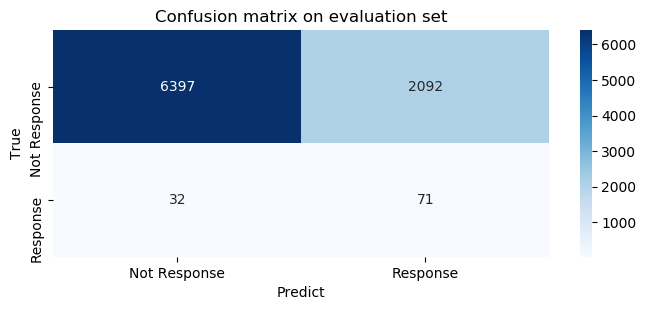

In [64]:
my_cv_ros = list(MyOverSamplerCV(X_train, y_train, n_splits=n_splits))
xgb_params_ros, xgb_rscv_ros = xgb_HyperParamTuning(my_cv_ros, dtrain, verbose=True)

##  Sets n_splits=1 so that we're training model for prediction rather than tuning hyper-parameters
my_NOcv_ros = list(MyOverSamplerCV(X_train, y_train, n_splits=1))
xgb_BestModels_ros = getBestModels(X_train, y_train, my_NOcv_ros, xgb_params=xgb_params_ros, ntrees=xgb_rscv_ros['cv_results'].shape[0])
_ = print_report(xgb_BestModels_ros, X_train, X_eval, y_train, y_eval)

1.(2) Undersampling + Ensemble: Only applying undersampling will lose a lot of informatin, so we combine it with ensemble.

For achieving our goal, we redefine a RandomSearchCV including UnderSampler based on the previous one.

In [65]:
def MyUnderSampler(idx,sample_size,seed):
    """ Do under-sampling without random picks so that each data point has the same weight. """
    np.random.seed(seed)
    RandomSamples = np.random.choice(idx, size=sample_size, replace=False)
    leftout_idx = np.array(list(set(idx) - set(RandomSamples.ravel()))) ## idx not sampled
    for i, idx in enumerate(RandomSamples):
        if i == 0: ## add leftout idx to not waste info
            idx = np.append(idx, leftout_idx)
        yield idx.astype(int)

def MyUnderOverSamplerCV(X,y,n_splits=7,n_batch=None,seed=RANDOM_SEED):
    """ 
        We make a stratified CV split without replacement so that each split has similar data strucutre and thus
    can be equally weighted when voting for choosing hyper-parameter.
        Moreover, n_batch controls whether we're using only RandomUnderSampler or RandomUnderSampler
    and RandomOverSampler together.
    """
    from imblearn.over_sampling import RandomOverSampler
    for train_idx, val_idx in MyStratifiedCV(X, y, n_splits, seed=seed):
        major_idx, minor_idx = train_idx[y[train_idx] == 0], train_idx[y[train_idx] == 1]
        n_major, n_minor = major_idx.shape[0], minor_idx.shape[0]
        
        if n_batch is None: ## (1) pure RandomUnderSampling
            sample_size = (n_major // n_minor, n_minor)
        else:  ## (2) RandomUnderSampling + OverSampling
            sample_size = (n_batch, n_major // n_batch)

        for i, major_rus_idx in enumerate(MyUnderSampler(major_idx, sample_size, seed=seed)):
            rus_idx = np.append(major_rus_idx, minor_idx)
            ruos_idx = MyOverSampler(X, y, rus_idx, seed+i)
            yield (ruos_idx, val_idx)

Using TensorFlow backend.


=======> 1-th search, train_auc:0.8131, train_std:0.0107, val_auc:0.7613, val_std:0.0232
=======> 2-th search, train_auc:0.8377, train_std:0.0098, val_auc:0.7626, val_std:0.0224
=======> 3-th search, train_auc:0.8422, train_std:0.0096, val_auc:0.7627, val_std:0.0224
=======> 4-th search, train_auc:0.8446, train_std:0.0094, val_auc:0.7627, val_std:0.0222
=======> 5-th search, train_auc:0.8403, train_std:0.0097, val_auc:0.7627, val_std:0.0223
=======> 6-th search, train_auc:0.8478, train_std:0.0089, val_auc:0.7626, val_std:0.0221
=======> 7-th search, train_auc:0.8426, train_std:0.0095, val_auc:0.7618, val_std:0.0221
best_params:{'max_depth': 2, 'eta': 0.02712272579332028}, best_auc(val):0.7627
=======> 1-th search, train_auc:0.7899, train_std:0.0107, val_auc:0.761, val_std:0.0208
=======> 2-th search, train_auc:0.8422, train_std:0.0096, val_auc:0.7627, val_std:0.0224
=======> 3-th search, train_auc:0.8461, train_std:0.0102, val_auc:0.7615, val_std:0.0231
best_params:{'max_depth': 2}, be

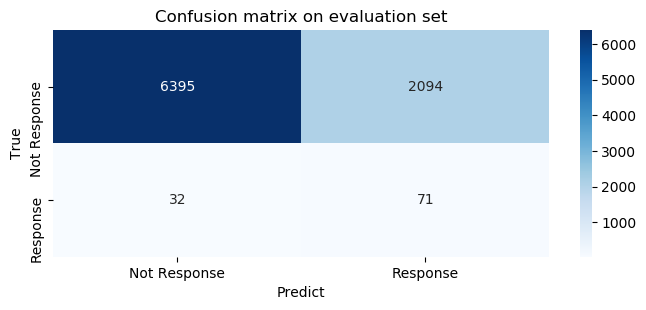

In [66]:
my_cv_rus = list(MyUnderOverSamplerCV(X_train, y_train, n_splits=n_splits))
xgb_params_rus, xgb_rscv_rus = xgb_HyperParamTuning(my_cv_rus, dtrain, max_bin=256)

##  Sets n_splits=1 so that we're training model for prediction rather than tuning hyper-parameters
my_NOcv_rus = list(MyUnderOverSamplerCV(X_train, y_train, n_splits=1))
xgb_BestModels_rus = getBestModels(X_train, y_train, my_NOcv_rus, xgb_params=xgb_params_rus, ntrees=xgb_rscv_rus['cv_results'].shape[0])
_ = print_report(xgb_BestModels_rus, X_train, X_eval, y_train, y_eval)

1.(3) Undersampling + Oversampling + Ensemble: We now combine oversampling and undersampling together with ensemble.

In [67]:
len(my_cv_rus) // n_splits

79

With only UnderSampler we get 79 mini batches, which not only can introduce noises but also makes computation very costly. Therefore, we reduce the number to 20 and see how it performs.

=======> 1-th search, train_auc:0.7951, train_std:0.0067, val_auc:0.7654, val_std:0.0242
=======> 2-th search, train_auc:0.8168, train_std:0.0056, val_auc:0.7668, val_std:0.0234
=======> 3-th search, train_auc:0.814, train_std:0.0057, val_auc:0.7668, val_std:0.0237
=======> 4-th search, train_auc:0.8149, train_std:0.0059, val_auc:0.7668, val_std:0.0232
=======> 5-th search, train_auc:0.8125, train_std:0.0058, val_auc:0.767, val_std:0.0234
=======> 6-th search, train_auc:0.8253, train_std:0.0056, val_auc:0.766, val_std:0.0228
=======> 7-th search, train_auc:0.8308, train_std:0.0052, val_auc:0.7658, val_std:0.0222
best_params:{'max_depth': 2, 'eta': 0.07356422544596414}, best_auc(val):0.767
=======> 1-th search, train_auc:0.809, train_std:0.0057, val_auc:0.7677, val_std:0.0188
=======> 2-th search, train_auc:0.8125, train_std:0.0058, val_auc:0.767, val_std:0.0234
=======> 3-th search, train_auc:0.8308, train_std:0.006, val_auc:0.762, val_std:0.0251
best_params:{'max_depth': 1}, best_auc(

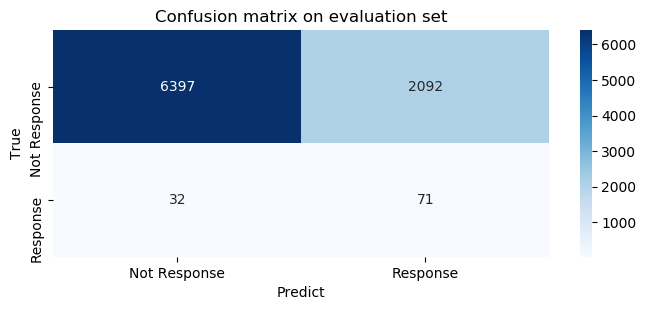

In [68]:
my_cv_ruos = list(MyUnderOverSamplerCV(X_train, y_train, n_splits=n_splits, n_batch=20))
xgb_params_ruos, xgb_rscv_ruos = xgb_HyperParamTuning(my_cv_ruos, dtrain, max_bin=256)

##  Sets n_splits=1 so that we're training model for prediction rather than tuning hyper-parameters
my_NOcv_ruos = list(MyUnderOverSamplerCV(X_train, y_train, n_splits=1, n_batch=20))
xgb_BestModels_ruos = getBestModels(X_train, y_train, my_NOcv_ruos, xgb_params=xgb_params_ruos, ntrees=xgb_rscv_ruos['cv_results'].shape[0])
_ = print_report(xgb_BestModels_ruos, X_train, X_eval, y_train, y_eval)

1. Undersampling + ensemble gives the best worse AUC but runs too slow.
2. Oversampling produces slightly worse result but is much computationally cheaper.
3. Unbalanced weight assignment is similar to oversampling, but there is a tiny gap here.

So we fianlly choose oversampling as winner.

### Model Stacking?

In [69]:
probas_train, names = [], []
xgb_weighted_proba_train = ensemble_proba([xgb_model_weighted], X_train, y_train)
probas_train.extend([xgb_weighted_proba_train])
names.extend(['xgb_weighted'])

lr_weighted_proba_train = ensemble_proba([lr_model_weighted], X_train, y_train)
probas_train.extend([lr_weighted_proba_train])
names.extend(['lr_weighted'])

svc_weighted_proba_train = ensemble_proba([svc_model_weighted], X_train, y_train)
probas_train.extend([svc_weighted_proba_train])
names.extend(['svc_weighted'])

rfc_weighted_proba_train = ensemble_proba([rfc_model_weighted], X_train, y_train)
probas_train.extend([rfc_weighted_proba_train])
names.extend(['rfc_weighted'])

base_corr_train = pd.DataFrame(probas_train, index=names).T.corr()
base_corr_train

,xgb_weighted,lr_weighted,svc_weighted,rfc_weighted
xgb_weighted,1.000000,0.579499,0.528343,0.908408
lr_weighted,0.579499,1.000000,0.960718,0.725805
svc_weighted,0.528343,0.960718,1.000000,0.652844
rfc_weighted,0.908408,0.725805,0.652844,1.000000


We use the default weight assignment to examine correlation among different models and obesrve

1. XGBoost and Random Forest(XGBoost based) perform best but are highly correlated.
2. Logistic regression and SVC can be used to stack with XGBoost due to low correlation, but they are too weak to be promising.

Thus, we leave model stacking as **a possible improvement** to be researched in the future.

### Carry out a finer parameter searching for XGBoost with Over-Sampling.

Now we make a more detailed tuning, but the differentce is that will train models for prediction. Namely, we will use the **entire** training set, so we first re-read training set and preprocess it.

In [70]:
mailout_train = pd.read_csv(os.path.join(os.getcwd(), 'mailout_train.csv'), sep=';')
mailout_train  = azdias_data_preprocessing(mailout_train)
assert((mailout_train.shape[1] - 1) == (customers.shape[1] - 3))

from sklearn.preprocessing import MinMaxScaler
mailout_train_pca = mailout_train[pca_features]
mailout_train_NonNegativeMin = np.where(mailout_train_pca<0, np.inf, mailout_train_pca).min(axis=0)
mailout_train_pca = mailout_train_pca - mailout_train_NonNegativeMin

ss_mailout_train = MinMaxScaler()
mailout_train_scaled = ss_mailout_train.fit_transform(mailout_train_pca)
mailout_train_PCs = pca.transform(mailout_train_scaled)[:, :num_PCs]
mailout_train_dist = kmeans.transform(mailout_train_PCs).min(axis=1).round(3)
mailout_train['CLUSTER_DIST'] = mailout_train_dist

In [71]:
X_train, y_train = mailout_train.drop(columns=['LNR', 'RESPONSE']).values, mailout_train['RESPONSE'].values
X_train_NonNegativeMin = np.where(X_train<0, np.inf, X_train).min(axis=0)
X_train = X_train - X_train_NonNegativeMin

In [72]:
rhos = np.corrcoef(X_train, rowvar=False)
variances = X_train.var(axis=0)

corr_thresh = 0.90
feature_kept_corr = []
for i in range(X_train.shape[1]):
        colinearity_loc = np.where(np.abs(rhos[:, i]) > corr_thresh)[0]
        self_var = variances[i]
        competitors_var = variances[colinearity_loc]
        ## we keep this feature if no other one is significantly correlated with it or it has the largest variance.
        if competitors_var.shape[0] == 0 or self_var >= np.max(competitors_var):
            feature_kept_corr.append(i)

feature_kept_corr = np.array(feature_kept_corr)
print(X_train.shape)
X_train = X_train[:, feature_kept_corr]
print(X_train.shape)

(42962, 360)
(42962, 278)


Next, we apply RandomForest Classifier for doing an embedded feature selection by setting max_feature = 1, i.e., selecting a single feature each time to observe its capacity to decrease the objective function.

(Note that this is am **in-sample(IS)** method.)

In [73]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=2*X_train.shape[1], max_features=1, random_state=RANDOM_SEED, n_jobs=4)
rfc.fit(X_train, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=1,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=556, n_jobs=4,
                       oob_score=False, random_state=2020, verbose=0,
                       warm_start=False)

In [74]:
feature_imp = rfc.feature_importances_
imp_argsort = np.argsort(feature_imp)[::-1]
num_feature = feature_imp.shape[0]

print(X_train.shape)
feature_kept_rfc = imp_argsort[:int(0.9*imp_argsort.shape[0])]
X_train = X_train[:, feature_kept_rfc]
print(X_train.shape)

(42962, 278)
(42962, 250)


In [75]:
from sklearn.preprocessing import MinMaxScaler
X_train = MinMaxScaler().fit_transform(X_train)
dtrain = xgb.DMatrix(X_train, y_train)

In [76]:
my_cv_ros = list(MyOverSamplerCV(X_train, y_train, n_splits=n_splits))
##  Sets n_splits=1 so that we're training model for prediction rather than tuning hyper-parameters
my_NOcv_ros = list(MyOverSamplerCV(X_train, y_train, n_splits=1))

Without an evaluation set, we will then develop our models based on validation set.

In [77]:
from sklearn.model_selection import ParameterSampler
xgb_params_ros= {'objective':'binary:logistic', 'eval_metric':'auc', 'tree_method':'hist', 'max_bin':256, 'nthread':8}

## We first tune the most important eta using grid-search
xgb_param_grid_ros={'eta': np.logspace(-2, -0.7, 7),
                                   'max_depth': np.arange(1,3)}
xgb_param_dist_ros = list(ParameterSampler(xgb_param_grid_ros, 21, RANDOM_SEED))
xgb_rscv_ros = MyRandomSearchCV(dtrain, xgb_params_ros, xgb_param_dist_ros, folds=my_cv_ros, maximize=True, verbose=True)
xgb_params_ros.update(xgb_rscv_ros['best_params'])

=======> 1-th search, train_auc:0.6313, train_std:0.002, val_auc:0.6313, val_std:0.0123
=======> 2-th search, train_auc:0.753, train_std:0.0041, val_auc:0.7451, val_std:0.0214
=======> 3-th search, train_auc:0.7547, train_std:0.0034, val_auc:0.7528, val_std:0.0199
=======> 4-th search, train_auc:0.8045, train_std:0.0035, val_auc:0.7644, val_std:0.0186
=======> 5-th search, train_auc:0.7547, train_std:0.0034, val_auc:0.7528, val_std:0.0199
=======> 6-th search, train_auc:0.8048, train_std:0.0036, val_auc:0.7643, val_std:0.0197
=======> 7-th search, train_auc:0.7853, train_std:0.004, val_auc:0.7673, val_std:0.0197
=======> 8-th search, train_auc:0.7994, train_std:0.0044, val_auc:0.7643, val_std:0.0186
=======> 9-th search, train_auc:0.79, train_std:0.0034, val_auc:0.7688, val_std:0.0195
=======> 10-th search, train_auc:0.8213, train_std:0.0029, val_auc:0.7654, val_std:0.018
=======> 11-th search, train_auc:0.8045, train_std:0.0024, val_auc:0.7721, val_std:0.0197
=======> 12-th search, tr

In [78]:
## We then make a finer search around the best parameter value
xgb_param_grid_ros={'eta': np.arange(0.8, 1.21, 0.05)*xgb_params_ros['eta']}
xgb_param_dist_ros = list(ParameterSampler(xgb_param_grid_ros, 9, RANDOM_SEED))
xgb_rscv_ros = MyRandomSearchCV(dtrain, xgb_params_ros, xgb_param_dist_ros, folds=my_cv_ros, maximize=True, verbose=True)
xgb_params_ros.update(xgb_rscv_ros['best_params'])

=======> 1-th search, train_auc:0.8042, train_std:0.0026, val_auc:0.7717, val_std:0.0197
=======> 2-th search, train_auc:0.7981, train_std:0.003, val_auc:0.7701, val_std:0.0193
=======> 3-th search, train_auc:0.7918, train_std:0.0033, val_auc:0.7693, val_std:0.0196
=======> 4-th search, train_auc:0.7983, train_std:0.0028, val_auc:0.7706, val_std:0.0194
=======> 5-th search, train_auc:0.8045, train_std:0.0024, val_auc:0.7721, val_std:0.0197
=======> 6-th search, train_auc:0.8072, train_std:0.0021, val_auc:0.7717, val_std:0.0198
=======> 7-th search, train_auc:0.7902, train_std:0.0031, val_auc:0.769, val_std:0.0193
=======> 8-th search, train_auc:0.8061, train_std:0.0022, val_auc:0.7714, val_std:0.0192
=======> 9-th search, train_auc:0.8067, train_std:0.0023, val_auc:0.7712, val_std:0.0192
best_params:{'eta': 0.12115276586285892}, best_auc(val):0.7721


In [79]:
## We fianlly tune less important parameters.
ntrain = my_cv_ros[0][0].shape[0]
NaiveLoss = -ntrain * np.log(0.5)                                                                  ## It's the loss based on random guess
xgb_param_grid_ros={'min_child_weight': np.linspace(1, ntrain//1e2, 5),  ## Our dataset is large, so using 1,2,3,4,... is meaningless
                                    'gamma': np.linspace(1, NaiveLoss//1e2, 5)}
DefaultParam = {'min_child_weight':1, 'gamma':0}                   ## In case the default works best
xgb_param_dist_ros = [DefaultParam] + list(ParameterSampler(xgb_param_grid_ros, 25, RANDOM_SEED))
xgb_rscv_ros = MyRandomSearchCV(dtrain, xgb_params_ros, xgb_param_dist_ros, folds=my_cv_ros, maximize=True, verbose=True)
xgb_params_ros.update(xgb_rscv_ros['best_params'])

=======> 1-th search, train_auc:0.8045, train_std:0.0024, val_auc:0.7721, val_std:0.0197
=======> 2-th search, train_auc:0.8045, train_std:0.0024, val_auc:0.7721, val_std:0.0197
=======> 3-th search, train_auc:0.7985, train_std:0.0027, val_auc:0.7709, val_std:0.0201
=======> 4-th search, train_auc:0.7978, train_std:0.003, val_auc:0.7718, val_std:0.0206
=======> 5-th search, train_auc:0.8015, train_std:0.0028, val_auc:0.773, val_std:0.0197
=======> 6-th search, train_auc:0.805, train_std:0.0026, val_auc:0.7746, val_std:0.0198
=======> 7-th search, train_auc:0.8045, train_std:0.0024, val_auc:0.7721, val_std:0.0197
=======> 8-th search, train_auc:0.7985, train_std:0.0027, val_auc:0.7709, val_std:0.0201
=======> 9-th search, train_auc:0.7978, train_std:0.003, val_auc:0.7718, val_std:0.0206
=======> 10-th search, train_auc:0.8015, train_std:0.0028, val_auc:0.773, val_std:0.0197
=======> 11-th search, train_auc:0.804, train_std:0.0027, val_auc:0.7739, val_std:0.0199
=======> 12-th search, tr

In [80]:
## We also make a finer search around the best parameter value
xgb_param_grid_ros={'min_child_weight': (np.arange(0.8, 1.21, 0.05)*xgb_params_ros['min_child_weight']).astype(int)}
DefaultParam = {'min_child_weight':1, 'gamma':0}                   ## In case the default works best
xgb_param_dist_ros = [DefaultParam] + list(ParameterSampler(xgb_param_grid_ros, 25, RANDOM_SEED))
xgb_rscv_ros = MyRandomSearchCV(dtrain, xgb_params_ros, xgb_param_dist_ros, folds=my_cv_ros, maximize=True, verbose=True)
xgb_params_ros.update(xgb_rscv_ros['best_params'])

=======> 1-th search, train_auc:0.8045, train_std:0.0024, val_auc:0.7721, val_std:0.0197
=======> 2-th search, train_auc:0.8016, train_std:0.0027, val_auc:0.7735, val_std:0.0202
=======> 3-th search, train_auc:0.8015, train_std:0.0027, val_auc:0.7735, val_std:0.0206
=======> 4-th search, train_auc:0.8048, train_std:0.0025, val_auc:0.7741, val_std:0.0196
=======> 5-th search, train_auc:0.8048, train_std:0.0025, val_auc:0.7741, val_std:0.0196
=======> 6-th search, train_auc:0.805, train_std:0.0026, val_auc:0.7746, val_std:0.0198
=======> 7-th search, train_auc:0.8048, train_std:0.0026, val_auc:0.7745, val_std:0.0202
=======> 8-th search, train_auc:0.8048, train_std:0.0026, val_auc:0.7745, val_std:0.0202
=======> 9-th search, train_auc:0.8048, train_std:0.0025, val_auc:0.7747, val_std:0.0198
=======> 10-th search, train_auc:0.8048, train_std:0.0024, val_auc:0.7746, val_std:0.0198
best_params:{'min_child_weight': 836}, best_auc(val):0.7747


Now, we get the final model!

In [81]:
xgb_BestModels_ros = getBestModels(X_train, y_train, my_NOcv_ros, xgb_params=xgb_params_ros, ntrees=xgb_rscv_ros['cv_results'].shape[0])

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

We read in the test set and do the same preprocessing as training set.

In [82]:
mailout_test = pd.read_csv(os.path.join(os.getcwd(), 'mailout_test.csv'), sep=';')
mailout_test  = azdias_data_preprocessing(mailout_test)
assert(mailout_test.shape[1] == (customers.shape[1] - 3))

from sklearn.preprocessing import MinMaxScaler
mailout_test_pca = mailout_test[pca_features]
mailout_test_NonNegativeMin = np.where(mailout_test_pca<0, np.inf, mailout_test_pca).min(axis=0)
mailout_test_pca = mailout_test_pca - mailout_test_NonNegativeMin

ss_mailout_test = MinMaxScaler()
mailout_test_scaled = ss_mailout_test.fit_transform(mailout_test_pca)
mailout_test_PCs = pca.transform(mailout_test_scaled)[:, :num_PCs]
mailout_test_dist = kmeans.transform(mailout_test_PCs).min(axis=1).round(3)
mailout_test['CLUSTER_DIST'] = mailout_test_dist

In [83]:
X_test, y_test = mailout_test.drop(columns=['LNR']).values, np.zeros(mailout_test.shape[0])
X_test_NonNegativeMin = np.where(X_test<0, np.inf, X_test).min(axis=0)
X_test = X_test - X_test_NonNegativeMin

X_test = X_test[:, feature_kept_corr][:, feature_kept_rfc]

ss_X_test = MinMaxScaler().fit_transform(X_test)
dtest = xgb.DMatrix(X_test, y_test)

In [84]:
y_proba = ensemble_proba(xgb_BestModels_ros, X_test, y_test)

result = pd.DataFrame(index=mailout_test.index)
result['LNR'] = mailout_test['LNR']
result['RESPONSE'] = y_proba

In [85]:
result.to_csv('/Users/heart/Desktop/ZhihuaZhang-Arvato-Result2.csv', index=False)

In [86]:
pd.read_csv('/Users/heart/Desktop/ZhihuaZhang-Arvato-Result2.csv').head()

,LNR,RESPONSE
0,1754,0.254158
1,1770,0.288457
2,1465,0.241959
3,1470,0.332060
4,1478,0.363801
